In [0]:
import sys
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from tensorflow.keras import backend as K

import tensorflow as tf
import tensorflow_probability as tfp
import networkx as nx

import math
import itertools

import collections
import pickle
from sklearn.metrics import mean_squared_error

In [0]:
MsemodelrmaePath = "/content/drive/My Drive/models/msemodelrmae.pkl"
MsemodelrmsePath = "/content/drive/My Drive/models/msemodelrmse.pkl"
MsemodelurmaePath = "/content/drive/My Drive/models/msemodelurmae.pkl"
MsemodelurmsePath = "/content/drive/My Drive/models/msemodelurmse.pkl"
MsemodelrrmsePath = "/content/drive/My Drive/models/msemodelrrmse.pkl"
MsemodelurrmsePath = "/content/drive/My Drive/models/msemodelurrmse.pkl"

#import os
#os.chdir("/content/drive/My Drive/models")
#!ls

In [3]:
df = pd.read_csv("/content/drive/My Drive/data/gcf/pricesvolumes.csv")

cols = [1,2,3,4,6,8,10,12,14,16,18,20,21,22,23,24,26,28,30,32,33,34,36,38,40,42]

df.drop(df.columns[cols],axis=1,inplace=True)
df.fillna(0, inplace=True)

print(len(df.columns)) # 17
print((df.columns)) # Index([u'Date', u'^DJI_prices', u'^GSPC_prices', u'^IXIC_prices', u'AAPL_prices', u'ABT_prices', u'AEM_prices', u'AFG_prices', u'APA_prices', u'B_prices', u'CAT_prices', u'FRD_prices', u'GIGA_prices', u'LAKE_prices', u'MCD_prices', u'MSFT_prices', u'ORCL_prices', u'SUN_prices', u'T_prices', u'UTX_prices', u'WWD_prices'], dtype='object')
print(len(df.index)) # 5285

allcols = df.columns.tolist()
print('allcols',allcols[1:])
df[allcols[1:]] = df[allcols[1:]].apply(pd.to_numeric).apply(lambda x: x/x.mean(), axis=0)

allcols.remove("Date")
allcols.remove("IXIC_prices")
allcols.remove("B_prices")
allcols.remove("LAKE_prices")
allcols.remove("SUN_prices")

17
Index(['Date', 'IXIC_prices', 'AAPL_prices', 'ABT_prices', 'AEM_prices',
       'AFG_prices', 'APA_prices', 'B_prices', 'CAT_prices', 'LAKE_prices',
       'MCD_prices', 'MSFT_prices', 'ORCL_prices', 'SUN_prices', 'T_prices',
       'UTX_prices', 'WWD_prices'],
      dtype='object')
5285
allcols ['IXIC_prices', 'AAPL_prices', 'ABT_prices', 'AEM_prices', 'AFG_prices', 'APA_prices', 'B_prices', 'CAT_prices', 'LAKE_prices', 'MCD_prices', 'MSFT_prices', 'ORCL_prices', 'SUN_prices', 'T_prices', 'UTX_prices', 'WWD_prices']


In [0]:
# inputbatchsize + p, inputbatchsize + q < 5285
inputbatchsize = 5000
p = 200
q = 200

percentilenum = 10
numepochs = 50

In [0]:
def getstockdata(dfone, lag):
    Ypast = []
    Ycurr = []
    for i in range(-inputbatchsize, 0):
        y = dfone.iloc[i,1]
        x = dfone.iloc[i - lag:i,1].tolist()
        Ypast.append(x)
        Ycurr.append(y)
    Ypast = np.vstack(Ypast)
    Ycurr = np.vstack(Ycurr)
    Ycurr = Ycurr.reshape(Ycurr.shape[0], )
    return Ypast,Ycurr

def fstat(rmse_ur, rmse_r):
    return (rmse_r-rmse_ur)/rmse_ur

def construct_graph(rmse_ur, rmse_r):
    rmse_keys = list(rmse_ur.keys())
    #graph_dict = collections.defaultdict(dict)
    graph_dict = {k:[] for k in rmse_ur}
    print(graph_dict)
    for k in rmse_keys:
        cand = rmse_ur[k]
        #graph_dict[k] = []
        for c in cand:
            fs = fstat(rmse_ur[k][c], rmse_r[k][c])
            if fs > 0.05:
                graph_dict[c].append(k)
        #if graph_dict[c] == []:
        #    graph_dict.pop(k, None)
    graph_dict = {k:v for (k,v) in graph_dict.items() if v != []}
    G = nx.DiGraph(graph_dict, directed=True)
    return G, graph_dict

In [0]:
# deep learning model for autoregression
def regression_model(lag, ypast_dim1):
    model = Sequential()
    model.add(Dense(units=2*lag, activation='relu', kernel_initializer='normal', bias_initializer='zeros', input_dim=ypast_dim1))
    model.add(Dropout(0.5))
    model.add(Dense(lag/2, activation='linear', kernel_initializer='normal', bias_initializer='zeros'))
    model.add(Dropout(0.2))
    model.add(Dense(lag/2, activation='relu', kernel_initializer='normal', bias_initializer='zeros'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, kernel_initializer='normal', bias_initializer='zeros'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # model.compile(loss='mse', optimizer='adam', metrics=['msd'])
    return model

In [8]:
model_r_mae = collections.defaultdict(dict)
model_r_mse = collections.defaultdict(dict)
model_r_rmse = collections.defaultdict(dict)
model_ur_mae = collections.defaultdict(dict)
model_ur_mse = collections.defaultdict(dict)
model_ur_rmse = collections.defaultdict(dict)

for stock1,stock2 in itertools.permutations(allcols,2):
    print('stock1,stock2',stock1,stock2)
    Ypast, Ycurr = getstockdata(df[['Date', stock1]],p)
    # Ypast,Ycurr = getstockdata(df[['Date','MSFT_prices']])
    numrecords = len(Ycurr)
    numtestrecords = int(math.ceil(0.3*numrecords))
    numtrainrecords = int(math.ceil(0.7*numrecords))
    model_r = regression_model(p, Ypast.shape[1])
    np.random.seed(3)
    model_r.fit(Ypast[:numtrainrecords], Ycurr[:numtrainrecords], epochs=numepochs, batch_size=32, verbose=2, validation_split=0.1)
    Ycurrp = model_r.predict(Ypast[-numtestrecords:], batch_size=128)
    mse_mse_value_r, mse_mae_value_r = model_r.evaluate(Ypast[-numtestrecords:], Ycurr[-numtestrecords:], batch_size=128, verbose=1)
    print('\n')
    print('mse modelr Ycurrp.mean()',Ycurrp.mean())
    print('mse modelr Ycurrp.std()',Ycurrp.std())
    print('mse modelr mae_value',mse_mae_value_r)
    print('mse modelr mse_value',mse_mse_value_r)
    print('mse modelr r2_score(Ycurrp, Ycurr)',r2_score(Ycurrp, Ycurr[-numtestrecords:]))
    model_r_rmse[stock1][stock2] = math.sqrt(mean_squared_error(Ycurrp, Ycurr[-numtestrecords:]))
    model_r_mae[stock1][stock2] = mse_mae_value_r
    model_r_mse[stock1][stock2] = mse_mse_value_r

    Ypast1, Ycurr1 = getstockdata(df[['Date', stock1]],p)
    Ypast2, Ycurr2 = getstockdata(df[['Date', stock2]],q)
    Ycurr2 = Ycurr1
    Ypast = np.concatenate((Ypast1, Ypast2))
    Ycurr = np.concatenate((Ycurr1, Ycurr2))

    numrecords = len(Ycurr)
    numtestrecords = int(math.ceil(0.3*numrecords))
    numtrainrecords = int(math.ceil(0.7*numrecords))
    model_ur = regression_model(q, Ypast.shape[1])
    np.random.seed(7)
    model_ur.fit(Ypast[:numtrainrecords], Ycurr[:numtrainrecords], epochs=numepochs, batch_size=32, verbose=2, validation_split=0.1)
    Ycurrp = model_ur.predict(Ypast[-numtestrecords:], batch_size=128)
    mse_mse_value_ur, mse_mae_value_ur = model_ur.evaluate(Ypast[-numtestrecords:], Ycurr[-numtestrecords:], batch_size=128, verbose=1)
    print('\n')
    print('mse modelur Ycurrp.mean()',Ycurrp.mean())
    print('mse modelur Ycurrp.std()',Ycurrp.std())
    print('mse modelur mae_value',mse_mae_value_ur)
    print('mse modelur mse_value',mse_mse_value_ur)
    print('mse modelur r2_score(Ycurrp, Ycurr)',r2_score(Ycurrp, Ycurr[-numtestrecords:]))
    model_ur_rmse[stock1][stock2] = math.sqrt(mean_squared_error(Ycurrp, Ycurr[-numtestrecords:]))
    model_ur_mae[stock1][stock2] = mse_mae_value_ur
    model_ur_mse[stock1][stock2] = mse_mse_value_ur

print('msemodelrmae', model_r_mae)
print('msemodelrmse', model_r_mse)
print('msemodelrrmse', model_r_rmse)
print('msemodelurmae', model_ur_mae)
print('msemodelurmse', model_ur_mse)
print('msemodelurrmse', model_ur_rmse)

with open(MsemodelrmaePath, 'wb') as handle:
    pickle.dump(model_r_mae, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MsemodelrmsePath, 'wb') as handle:
    pickle.dump(model_r_mse, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MsemodelrrmsePath, 'wb') as handle:
    pickle.dump(model_r_rmse, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MsemodelurmaePath, 'wb') as handle:
    pickle.dump(model_ur_mae, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MsemodelurmsePath, 'wb') as handle:
    pickle.dump(model_ur_mse, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(MsemodelurrmsePath, 'wb') as handle:
    pickle.dump(model_ur_rmse, handle, protocol=pickle.HIGHEST_PROTOCOL)

Streaming output truncated to the last 5000 lines.
mse modelur mse_value 0.03591281548142433
mse modelur r2_score(Ycurrp, Ycurr) -10.940740590738239
stock1,stock2 T_prices WWD_prices
Epoch 1/50
99/99 - 0s - loss: 0.1077 - mae: 0.2403 - val_loss: 0.0196 - val_mae: 0.1355
Epoch 2/50
99/99 - 0s - loss: 0.0578 - mae: 0.1858 - val_loss: 0.0140 - val_mae: 0.1144
Epoch 3/50
99/99 - 0s - loss: 0.0459 - mae: 0.1640 - val_loss: 0.0038 - val_mae: 0.0550
Epoch 4/50
99/99 - 0s - loss: 0.0443 - mae: 0.1627 - val_loss: 0.0045 - val_mae: 0.0613
Epoch 5/50
99/99 - 0s - loss: 0.0398 - mae: 0.1537 - val_loss: 0.0035 - val_mae: 0.0527
Epoch 6/50
99/99 - 0s - loss: 0.0414 - mae: 0.1566 - val_loss: 0.0038 - val_mae: 0.0561
Epoch 7/50
99/99 - 0s - loss: 0.0422 - mae: 0.1571 - val_loss: 7.8894e-04 - val_mae: 0.0238
Epoch 8/50
99/99 - 0s - loss: 0.0376 - mae: 0.1486 - val_loss: 0.0054 - val_mae: 0.0677
Epoch 9/50
99/99 - 0s - loss: 0.0385 - mae: 0.1501 - val_loss: 0.0021 - val_mae: 0.0387
Epoch 10/50
99/99 - 0

{'AAPL_prices': [], 'ABT_prices': [], 'AEM_prices': [], 'AFG_prices': [], 'APA_prices': [], 'CAT_prices': [], 'MCD_prices': [], 'MSFT_prices': [], 'ORCL_prices': [], 'T_prices': [], 'UTX_prices': [], 'WWD_prices': []}


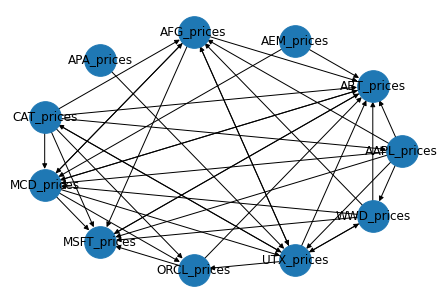

In [11]:
G, g_dict = construct_graph(model_ur_rmse,model_r_rmse)

options = {
  'node_size': 1000,
  'width': 1,
  'arrowstyle': '-|>',
  'arrowsize': 10,
}

pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, **options)